## 8. Final Assignment: Neural Network on Pima Indians Diabetes Dataset

### Assignment Overview
Apply the **exact same neural network pipeline** from this lab to a **new dataset**: Pima Indians Diabetes

**Goal**: Reproduce the complete workflow (load → explore → preprocess → build → train → evaluate) on different data to demonstrate generalization

### Dataset: Pima Indians Diabetes

**Source**: UCI Machine Learning Repository  
**URL**: `https://archive.ics.uci.edu/ml/machine-learning-databases/pima-indians-diabetes/pima-indians-diabetes.data`  
**Target**: Diabetes (0=No, 1=Yes)  
**Expected Accuracy**: 70-75% (harder than Heart Disease!)  

### Your Tasks

#### Part 1: Build & Train 
#### Part 2: Analysis & Interpretation
#### Part 3: Submission 
Create GitHub repository with:
```
neural-network-diabetes/
├── pima_diabetes_nn.ipynb          (Your complete notebook)
├── README.md                        (Documented findings)
└── results/
    ├── training_curves.png
    ├── confusion_matrix.png
    └── metrics_summary.txt
```



### Submission Checklist
-  Notebook fully runnable (no errors)
-  All visualizations present (training curves, confusion matrix)
-  Test accuracy reported clearly
-  README explains problem, approach, and results
-  GitHub repo is public with all files
-  Code is commented and readable
-  Analysis writeup is comprehensive (3-5 paragraphs)
-  Link of uploaded recorded video ⚠️

## Step 1: Import Libraries

Import all necessary libraries for data processing, visualization, model building, and evaluation. We set random seeds (`numpy` and `tensorflow`) at the top to ensure **reproducible results** across runs.

In [27]:
# Set random seeds for reproducible results
import numpy as np
np.random.seed(42)
import tensorflow as tf
tf.random.set_seed(42)

import os
import kagglehub
# Data processing and visualization
import numpy as np                           # Numerical computing
import pandas as pd                          # Data manipulation
from sklearn.datasets import load_breast_cancer  # Load biomedical dataset
from sklearn.model_selection import train_test_split  # Split data into train/test
from sklearn.preprocessing import StandardScaler    # Scale features (normalize values)
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score  # Evaluation metrics

# Deep learning
from tensorflow.keras import models, layers  # Build neural network
from tensorflow.keras.optimizers import Adam  # Optimizer for training
from tensorflow.keras.callbacks import EarlyStopping  # Stop training when validation loss plateaus

# Visualization
import matplotlib.pyplot as plt              # Plot training curves and results
import seaborn as sns                        # Enhanced visualizations

print("✓ All libraries imported successfully!")

✓ All libraries imported successfully!


## Step 2: Load the Dataset

Load the **Pima Indians Diabetes** dataset from a local CSV file. The dataset contains 768 samples with 8 medical predictor features and a binary target column (`Outcome`: 0 = No Diabetes, 1 = Diabetes). We extract features (`X`) and labels (`y`) and display basic shape information.

In [28]:

path = kagglehub.dataset_download("uciml/pima-indians-diabetes-database")
print("Dataset path:", path)
csv_path = os.path.join(path, "diabetes.csv")
# Load data using pandas
data = pd.read_csv(csv_path)

# Remove rows with missing values
data = data.dropna()

print(f"Dataset downloaded successfully!")
print(f"Total samples after removing missing values: {data.shape[0]}")

# Extract features (X) and labels (y)
X = data.drop('Outcome', axis=1).values
y = (data['Outcome'] > 0).astype(int).values  # Convert to binary (0 or 1)

# Get feature names for reference
feature_names = data.columns[:-1].tolist()
target_names = np.array(['Non Diabatic', 'Diabatic'])

print(f"\nFeatures shape: {X.shape}")
print(f"Labels shape: {y.shape}")
print(f"Feature names: {feature_names}")
print(f"Target classes: {target_names}")

Dataset path: C:\Users\DELL\.cache\kagglehub\datasets\uciml\pima-indians-diabetes-database\versions\1
Dataset downloaded successfully!
Total samples after removing missing values: 768

Features shape: (768, 8)
Labels shape: (768,)
Feature names: ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']
Target classes: ['Non Diabatic' 'Diabatic']


## Step 3: Explore the Dataset

Perform initial **exploratory data analysis (EDA)** to understand class distribution and feature value ranges. This step is crucial for identifying class imbalance and confirming that features need normalization due to different scales.

In [3]:
# Explore the dataset structure
print("=" * 70)
print("Diabetes DATASET EXPLORATION")
print("=" * 70)

print(f"\nTotal samples: {X.shape[0]}")
print(f"Total features: {X.shape[1]}")

print(f"\nClass Distribution:")
print(f"  No Diabetes (0): {np.sum(y == 0)} samples ({100*np.sum(y==0)/len(y):.1f}%)")
print(f"  Diabetes (1): {np.sum(y == 1)} samples ({100*np.sum(y==1)/len(y):.1f}%)")

print(f"\nFeature Value Ranges (varies by measurement type):")
print(f"  Min values: {X.min(axis=0)[:5]}")
print(f"  Max values: {X.max(axis=0)[:5]}")
print(f"  Note: Features have very different scales → MUST normalize!")

Diabetes DATASET EXPLORATION

Total samples: 768
Total features: 8

Class Distribution:
  No Diabetes (0): 500 samples (65.1%)
  Diabetes (1): 268 samples (34.9%)

Feature Value Ranges (varies by measurement type):
  Min values: [0. 0. 0. 0. 0.]
  Max values: [ 17. 199. 122.  99. 846.]
  Note: Features have very different scales → MUST normalize!


## Step 4: Outlier Detection & Removal

Use **Z-score analysis** to detect and remove outliers from the dataset. Any sample with a feature value more than 3 standard deviations from the mean is considered an outlier. This helps improve model robustness by removing extreme values that could skew training.

In [4]:
from scipy import stats

feature_cols = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 
                'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']

# Calculate Z-scores for feature columns
z_scores = np.abs(stats.zscore(data[feature_cols].values))

# Threshold: remove rows where ANY feature has |z| > 3
threshold = 3
outlier_mask = (z_scores < threshold).all(axis=1)

# Show outliers per column
print(f"\nDetecting outliers (Z-Score > {threshold}):")
for i, col in enumerate(feature_cols):
    outliers = (np.abs(z_scores[:, i]) >= threshold).sum()
    if outliers > 0:
        print(f"  {col}: {outliers} outliers found")

data_clean = data[outlier_mask]

print(f"\nSamples after outlier removal: {data_clean.shape[0]}")
print(f"Removed: {data.shape[0] - data_clean.shape[0]} outlier rows ({100*(data.shape[0] - data_clean.shape[0])/data.shape[0]:.1f}%)")

# Extract features (X) and labels (y)
X = data_clean.drop('Outcome', axis=1).values
y = (data_clean['Outcome'] > 0).astype(int).values

feature_names = data_clean.columns[:-1].tolist()
target_names = np.array(['Non Diabetic', 'Diabetic'])

print(f"\nFeatures shape: {X.shape}")
print(f"Labels shape: {y.shape}")
print(f"\nClass Distribution after cleaning:")
print(f"  No Diabetes (0): {np.sum(y == 0)} samples ({100*np.sum(y==0)/len(y):.1f}%)")
print(f"  Diabetes (1): {np.sum(y == 1)} samples ({100*np.sum(y==1)/len(y):.1f}%)")


Detecting outliers (Z-Score > 3):
  Pregnancies: 4 outliers found
  Glucose: 5 outliers found
  BloodPressure: 35 outliers found
  SkinThickness: 1 outliers found
  Insulin: 18 outliers found
  BMI: 14 outliers found
  DiabetesPedigreeFunction: 11 outliers found
  Age: 5 outliers found

Samples after outlier removal: 688
Removed: 80 outlier rows (10.4%)

Features shape: (688, 8)
Labels shape: (688,)

Class Distribution after cleaning:
  No Diabetes (0): 461 samples (67.0%)
  Diabetes (1): 227 samples (33.0%)


## Step 5: Train-Test Split

Split the cleaned dataset into **80% training** and **20% testing** sets using stratified sampling to preserve the class distribution in both sets. This ensures the model is evaluated on data it has never seen during training.

In [5]:
# Step 1: Split data into training and testing sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2,           # 20% for testing
    random_state=42,         # For reproducibility
    stratify=y               # Keep class distribution in both sets
)

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Testing set size: {X_test.shape[0]} samples")
print(f"\nTraining set class distribution:")
print(f"  No Diabetes: {np.sum(y_train == 0)} ({100*np.sum(y_train==0)/len(y_train):.1f}%)")
print(f"  Diabetes: {np.sum(y_train == 1)} ({100*np.sum(y_train==1)/len(y_train):.1f}%)")

print(f"\nBefore Scaling - Feature Statistics:")
print(f"  Mean: {X_train.mean(axis=0)[:3]}")
print(f"  Std Dev: {X_train.std(axis=0)[:3]}")

Training set size: 550 samples
Testing set size: 138 samples

Training set class distribution:
  No Diabetes: 369 (67.1%)
  Diabetes: 181 (32.9%)

Before Scaling - Feature Statistics:
  Mean: [  3.93636364 120.37454545  72.32      ]
  Std Dev: [ 3.28488902 29.97595532 12.34575231]


## Step 6: Feature Scaling (Standardization)

Apply **StandardScaler** to normalize all features to have zero mean and unit variance. The scaler is fit **only on training data** to prevent data leakage — the test set is transformed using the same statistics learned from training data.

In [6]:
# Step 2: Scale features using StandardScaler
scaler = StandardScaler()

# Fit on training data and transform it
X_train_scaled = scaler.fit_transform(X_train)

# Transform test data using training statistics (DO NOT refit!)
X_test_scaled = scaler.transform(X_test)

print("After Scaling - Feature Statistics:")
print(f"  Training mean: {X_train_scaled.mean(axis=0)[:3]} (should be ~0)")
print(f"  Training std dev: {X_train_scaled.std(axis=0)[:3]} (should be ~1)")
print(f"  Test mean: {X_test_scaled.mean(axis=0)[:3]} (close to 0)")
print(f"  Test std dev: {X_test_scaled.std(axis=0)[:3]} (close to 1)")

print(f"\n✓ Data preprocessing complete!")

After Scaling - Feature Statistics:
  Training mean: [-3.99680289e-17 -1.93784382e-17  5.07371922e-16] (should be ~0)
  Training std dev: [1. 1. 1.] (should be ~1)
  Test mean: [-0.13725164 -0.01346182  0.01047124] (close to 0)
  Test std dev: [0.98012008 1.00126087 0.9829415 ] (close to 1)

✓ Data preprocessing complete!


## Step 7: Build the Neural Network Model

Construct a **Sequential neural network** with the following architecture:
- **Input layer**: 64 neurons, `tanh` activation (8 input features)
- **Hidden layer 1**: 32 neurons, `tanh` activation
- **Hidden layer 2**: 16 neurons, `tanh` activation
- **Output layer**: 1 neuron, `sigmoid` activation (binary classification)

**Dropout layers** (30% and 20%) are added after each hidden layer to regularize the model and reduce overfitting.

In [ ]:
# Reset seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

model = models.Sequential([
    layers.Dense(64, activation='tanh', input_shape=(8,)),
    layers.Dropout(0.3),                    # Prevent overfitting
    layers.Dense(32, activation='tanh'),
    layers.Dropout(0.2),
    layers.Dense(16, activation='tanh'),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')
])

# Display model architecture
print("Model Architecture:")
model.summary()

Model Architecture:
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                576       
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 16)                528       
                                                                 
 dropout_2 (Dropout)         (None, 16)                0         
                                                                 
 dense_3 (Dense)             (None, 

## Step 8: Compile the Model

Configure the model for training:
- **Optimizer**: Adam with a learning rate of `0.0005` (adaptive gradient descent)
- **Loss function**: Binary crossentropy (standard for binary classification)
- **Metric**: Binary accuracy to monitor during training

In [8]:
# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.0005),        # Adaptive optimizer
    loss='binary_crossentropy',                 # For binary classification
    metrics=['binary_accuracy']                 # Track accuracy during training
)

print("✓ Model compiled successfully!")

✓ Model compiled successfully!


## Step 9: Train the Model with Early Stopping

Train the model for up to **200 epochs** with **Early Stopping** enabled:
- Monitors `val_loss` and stops training if no improvement for 20 consecutive epochs
- Restores the **best weights** automatically
- Uses a **20% validation split** from the training data to track generalization
- Batch size of 32 samples per gradient update

In [9]:
# Set up Early Stopping to prevent overfitting
early_stop = EarlyStopping(
    monitor='val_loss',                      # Watch validation loss
    patience=20,                              # Stop if no improvement for 20 epochs (more time to explore)
    restore_best_weights=True,               # Return to best weights
    verbose=1
)

# Train the model with Early Stopping
print("Starting training with Early Stopping...")
history = model.fit(
    X_train_scaled, y_train,
    epochs=200,                              # Max epochs (may stop early)
    batch_size=32,                           # Samples per gradient update
    validation_split=0.2,                    # Use 20% of training data for validation
    callbacks=[early_stop],                  # Apply early stopping
    verbose=1                                # Show progress bar
)

print("\n✓ Training complete! Model stopped at best validation performance.")

Starting training with Early Stopping...
Epoch 1/200
14/14 [==============================] - 1s 19ms/step - loss: 0.7209 - binary_accuracy: 0.5841 - val_loss: 0.5690 - val_binary_accuracy: 0.6545
Epoch 2/200
14/14 [==============================] - 0s 5ms/step - loss: 0.5909 - binary_accuracy: 0.6773 - val_loss: 0.4844 - val_binary_accuracy: 0.7818
Epoch 3/200
14/14 [==============================] - 0s 6ms/step - loss: 0.5752 - binary_accuracy: 0.6977 - val_loss: 0.4651 - val_binary_accuracy: 0.7909
Epoch 4/200
14/14 [==============================] - 0s 4ms/step - loss: 0.5497 - binary_accuracy: 0.7136 - val_loss: 0.4558 - val_binary_accuracy: 0.8091
Epoch 5/200
14/14 [==============================] - 0s 5ms/step - loss: 0.5506 - binary_accuracy: 0.7273 - val_loss: 0.4544 - val_binary_accuracy: 0.8000
Epoch 6/200
14/14 [==============================] - 0s 5ms/step - loss: 0.4969 - binary_accuracy: 0.7364 - val_loss: 0.4442 - val_binary_accuracy: 0.7909
Epoch 7/200
14/14 [=========

## Step 10: Visualize Training Curves

Plot **accuracy** and **loss** curves for both training and validation sets across epochs. These curves help diagnose:
- **Overfitting**: when training accuracy keeps rising but validation accuracy plateaus or drops
- **Underfitting**: when both curves remain low
- **Good fit**: when both curves converge and stabilize together

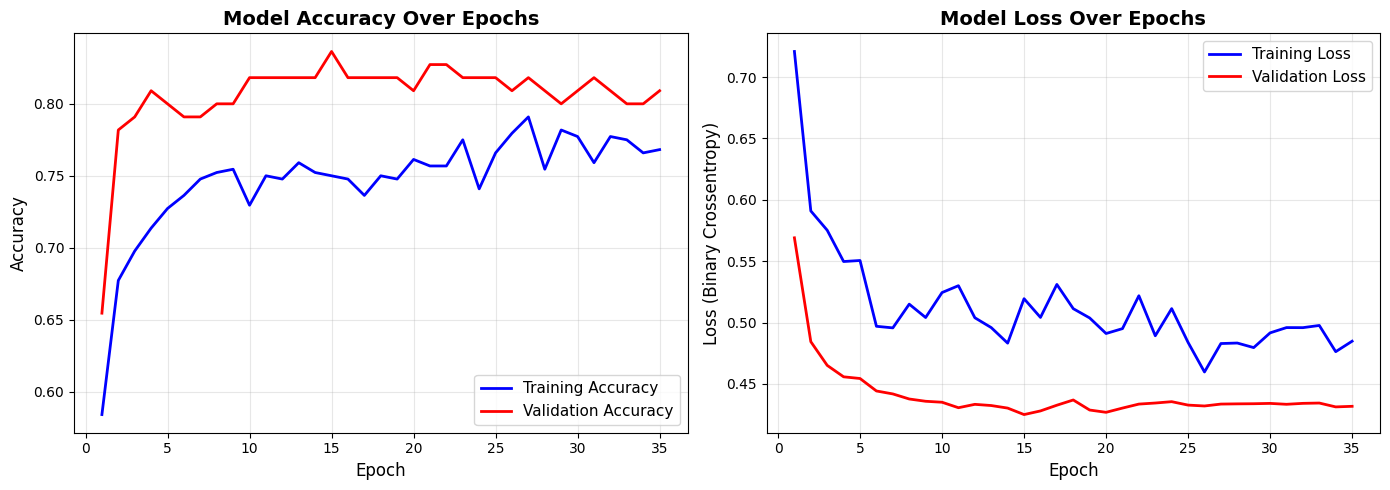

✓ Training curves saved to results/training_curves.png
✓ Training visualization complete!


In [10]:
# Extract history data
loss_values = history.history['loss']
val_loss_values = history.history['val_loss']
accuracy_values = history.history['binary_accuracy']
val_accuracy_values = history.history['val_binary_accuracy']

epochs = range(1, len(loss_values) + 1)

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Accuracy
ax1.plot(epochs, accuracy_values, 'b-', label='Training Accuracy', linewidth=2)
ax1.plot(epochs, val_accuracy_values, 'r-', label='Validation Accuracy', linewidth=2)
ax1.set_title('Model Accuracy Over Epochs', fontsize=14, fontweight='bold')
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)
# ax1.set_ylim([0.8, 1.0])  # Removed: was hiding validation accuracy below 0.8

# Plot 2: Loss
ax2.plot(epochs, loss_values, 'b-', label='Training Loss', linewidth=2)
ax2.plot(epochs, val_loss_values, 'r-', label='Validation Loss', linewidth=2)
ax2.set_title('Model Loss Over Epochs', fontsize=14, fontweight='bold')
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Loss (Binary Crossentropy)', fontsize=12)
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('./results/training_curves.png', dpi=150, bbox_inches='tight')
plt.show()


print("✓ Training curves saved to results/training_curves.png")
print("✓ Training visualization complete!")

## Step 11: Evaluate on Test Data

Evaluate the trained model on the **held-out test set** (data the model has never seen). This gives an unbiased estimate of the model's real-world performance. We report both the test loss and test accuracy.

In [11]:
# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test, verbose=0)

print("=" * 70)
print("MODEL EVALUATION ON TEST DATA")
print("=" * 70)
print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print("\n✓ Model successfully evaluated on unseen test data!")

MODEL EVALUATION ON TEST DATA

Test Loss: 0.4291
Test Accuracy: 0.7899 (78.99%)

✓ Model successfully evaluated on unseen test data!


## Step 12: Confusion Matrix

Generate and visualize the **confusion matrix** to understand the model's prediction breakdown:
- **True Positives / True Negatives**: correct predictions
- **False Positives / False Negatives**: misclassifications

This is especially important in medical diagnosis where missing a diabetic patient (False Negative) has serious consequences.

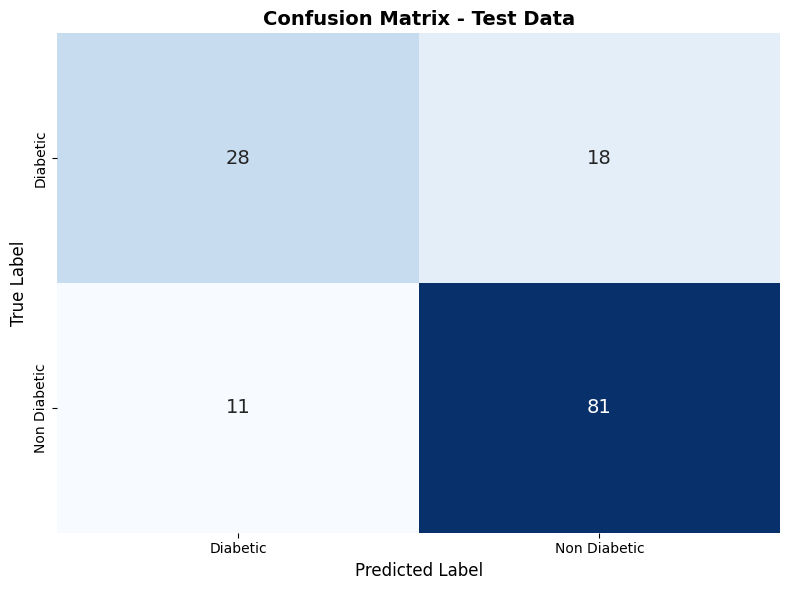

✓ Confusion matrix saved to results/confusion_matrix.png

Confusion Matrix Breakdown:
  True Negatives (TN):  81  (Correctly identified non-diabetic)
  True Positives (TP):  28  (Correctly identified diabetic)
  False Positives (FP): 11  (Non-diabetic predicted as diabetic)
  False Negatives (FN): 18  (Diabetic predicted as non-diabetic) ⚠️


In [20]:
# Make predictions on test data
y_pred_prob = model.predict(X_test_scaled, verbose=0)  # Get probabilities
y_pred = (y_pred_prob > 0.5).astype(int).flatten()  # Convert to class labels (0 or 1)

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred, labels= [1 , 0])  # Ensure correct order of labels

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Diabetic', 'Non Diabetic'],
            yticklabels=['Diabetic', 'Non Diabetic'],
            annot_kws={'size': 14})
plt.title('Confusion Matrix - Test Data', fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.savefig('./results/confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Confusion matrix saved to results/confusion_matrix.png")

print("\nConfusion Matrix Breakdown:")
print(f"  True Negatives (TN):  {cm[1, 1]}  (Correctly identified non-diabetic)")
print(f"  True Positives (TP):  {cm[0, 0]}  (Correctly identified diabetic)")
print(f"  False Positives (FP): {cm[1, 0]}  (Non-diabetic predicted as diabetic)")
print(f"  False Negatives (FN): {cm[0, 1]}  (Diabetic predicted as non-diabetic) ⚠️")

## Step 13: Detailed Classification Metrics

Compute and report comprehensive classification metrics:
- **Precision**: of all predicted positives, how many are correct
- **Recall (Sensitivity)**: of all actual positives, how many are caught
- **F1-Score**: harmonic mean of precision and recall

In a medical context, **recall for the diabetic class is critical** — we want to minimize missed diagnoses even at the cost of some false alarms.

In [ ]:
import os

# Calculate overall metrics (default pos_label=1 → Diabetic class)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Calculate per-class metrics
precision_non_diabetic = precision_score(y_test, y_pred, pos_label=0)
recall_non_diabetic = recall_score(y_test, y_pred, pos_label=0)


print("=" * 70)
print("DETAILED CLASSIFICATION METRICS")
print("=" * 70)

print(f"\nOverall Metrics:")
print(f"  Accuracy:  {test_accuracy:.4f}")
print(f"  Precision: {precision:.4f} (of predicted diabetic, {precision*100:.2f}% are correct)")
print(f"  Recall:    {recall:.4f} (we catch {recall*100:.2f}% of actual diabetic cases)")
print(f"  F1-Score:  {f1:.4f} (harmonic mean of precision and recall)")

print(f"\nNon-Diabetic (Class 0):")
print(f"  Precision: {precision_non_diabetic:.4f}")
print(f"  Recall:    {recall_non_diabetic:.4f} (catch {recall_non_diabetic*100:.2f}% of non-diabetic cases)")


# Save metrics summary to file
os.makedirs('./results', exist_ok=True)
with open('./results/metrics_summary.txt', 'w') as f:
    f.write("=" * 70 + "\n")
    f.write("PIMA INDIANS DIABETES - CLASSIFICATION METRICS SUMMARY\n")
    f.write("=" * 70 + "\n\n")
    f.write(f"Test Loss:     {test_loss:.4f}\n")
    f.write(f"Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)\n\n")
    f.write(f"Overall Metrics (Diabetic = positive class):\n")
    f.write(f"  Precision: {precision:.4f}\n")
    f.write(f"  Recall:    {recall:.4f}\n")
    f.write(f"  F1-Score:  {f1:.4f}\n\n")
    f.write(f"Non-Diabetic (Class 0):\n")
    f.write(f"  Precision: {precision_non_diabetic:.4f}\n")
    f.write(f"  Recall:    {recall_non_diabetic:.4f}\n\n")
    f.write(f"Diabetic (Class 1):\n")
    f.write(f"  Precision: {precision:.4f}\n")
    f.write(f"  Recall:    {recall:.4f}\n\n")
    print(f"\n✓ Metrics summary saved to results/metrics_summary.txt")

DETAILED CLASSIFICATION METRICS

Overall Metrics:
  Accuracy:  0.7899
  Precision: 0.7179 (of predicted diabetic, 71.79% are correct)
  Recall:    0.6087 (we catch 60.87% of actual diabetic cases)
  F1-Score:  0.6588 (harmonic mean of precision and recall)

Non-Diabetic (Class 0):
  Precision: 0.8182
  Recall:    0.8804 (catch 88.04% of non-diabetic cases)

✓ Metrics summary saved to results/metrics_summary.txt
